# Clustering of spots to discover spatial regions of interest

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
from scipy.io import mmread
sc.settings.n_jobs=4
sc.set_figure_params(figsize=(6, 6), frameon=False)


### List all slides

In [2]:
# create a dictionary of data paths
data_dir_dict = {
    # adjacent normal
    'HCC_1N' : './raw_data/Adjacent/HCC-1N',
    'HCC_2N' : './raw_data/Adjacent/HCC-2N',
    'HCC_3N' : './raw_data/Adjacent/HCC-3N',
    'HCC_4N' : './raw_data/Adjacent/HCC-4N',
    'cHC_1N' : './raw_data/Adjacent/cHC-1N',

    # leading edge
    'HCC_1L' : './raw_data/Leading_Edge/HCC-1L',
    'HCC_2L' : './raw_data/Leading_Edge/HCC-2L',
    'HCC_3L' : './raw_data/Leading_Edge/HCC-3L',
    'HCC_4L' : './raw_data/Leading_Edge/HCC-4L',
    'cHC_1L' : './raw_data/Leading_Edge/cHC-1L',
    'iCC_1L' : './raw_data/Leading_Edge/ICC-1L',

    # primary tumor
    'HCC_1T' : './raw_data/Primary_Tumor/HCC-1T',
    'HCC_2T' : './raw_data/Primary_Tumor/HCC-2T',
    'HCC_3T' : './raw_data/Primary_Tumor/HCC-3T',
    'HCC_4T' : './raw_data/Primary_Tumor/HCC-4T',
    'cHC_1T' : './raw_data/Primary_Tumor/cHC-1T'
}

In [3]:
# Read in all slide and store in a dict
adata_dict = {}
for key, value in data_dir_dict.items():
    adata = sc.read_visium(value)
    adata.var_names_make_unique()
    adata.obs['sample'] = key
    # add slide name to obs index
    adata.obs.index = key + '_' + adata.obs.index
    adata_dict[key] = adata

/home/xinghua/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/xinghua/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/xinghua/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/xinghua/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/xinghua/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To m

In [4]:
# print out the number of genes and cells in each slide
for key, value in adata_dict.items():
    print(key, value.shape)

HCC_1N (2956, 33538)
HCC_2N (4628, 33538)
HCC_3N (4289, 33538)
HCC_4N (4397, 33538)
cHC_1N (2207, 33538)
HCC_1L (2791, 33538)
HCC_2L (4672, 33538)
HCC_3L (4758, 33538)
HCC_4L (4113, 33538)
cHC_1L (4516, 33538)
iCC_1L (4654, 33538)
HCC_1T (3184, 33538)
HCC_2T (4733, 33538)
HCC_3T (4456, 33538)
HCC_4T (4162, 33538)
cHC_1T (4779, 33538)


### Plot spatial images of all slides

In [ ]:
# plot images from each visium in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
for i, (key, value) in enumerate(adata_dict.items()):
    sc.pl.spatial(value, img_key="hires", ax=axes[i//4, i%4], alpha_img=1,show=False)
    axes[i//4, i%4].set_title(key)

### Qaulity control of spots
1. remove genes with low counts
2. remove spots with low counts
3. select highly variable genes
4. PCA
5. Leiden clustering
6. UMAP
7. Harmony integration
8. Leiden clustering
9. UMAP

In [ ]:
# label mitochondria genes and perform basic QC
for key, value in adata_dict.items():
    adata = adata_dict[key]
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In [ ]:
# plot QC metrics
for key, value in adata_dict.items():
    adata = adata_dict[key]
    print(key)
    sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
                 jitter=0.0, multi_panel=True, show=False)
    sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])


### Concatenate all slides


In [5]:
adata = ad.concat(adata_dict.values())
adata.shape

(65295, 33538)

In [6]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)

In [7]:
adata.shape

(65295, 33538)

In [8]:
# save highly variable genes
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
adata.shape

(65295, 3000)

In [9]:
# perform PCA
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver="arpack")

In [ ]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
# clustering using leiden algorithm


In [11]:
sc.tl.leiden(adata, resolution=1.0, key_added="leiden")
sc.tl.umap(adata, min_dist=0.3)


/home/xinghua/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/xinghua/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'sample'}, xlabel='UMAP1', ylabel='UMAP2'>]

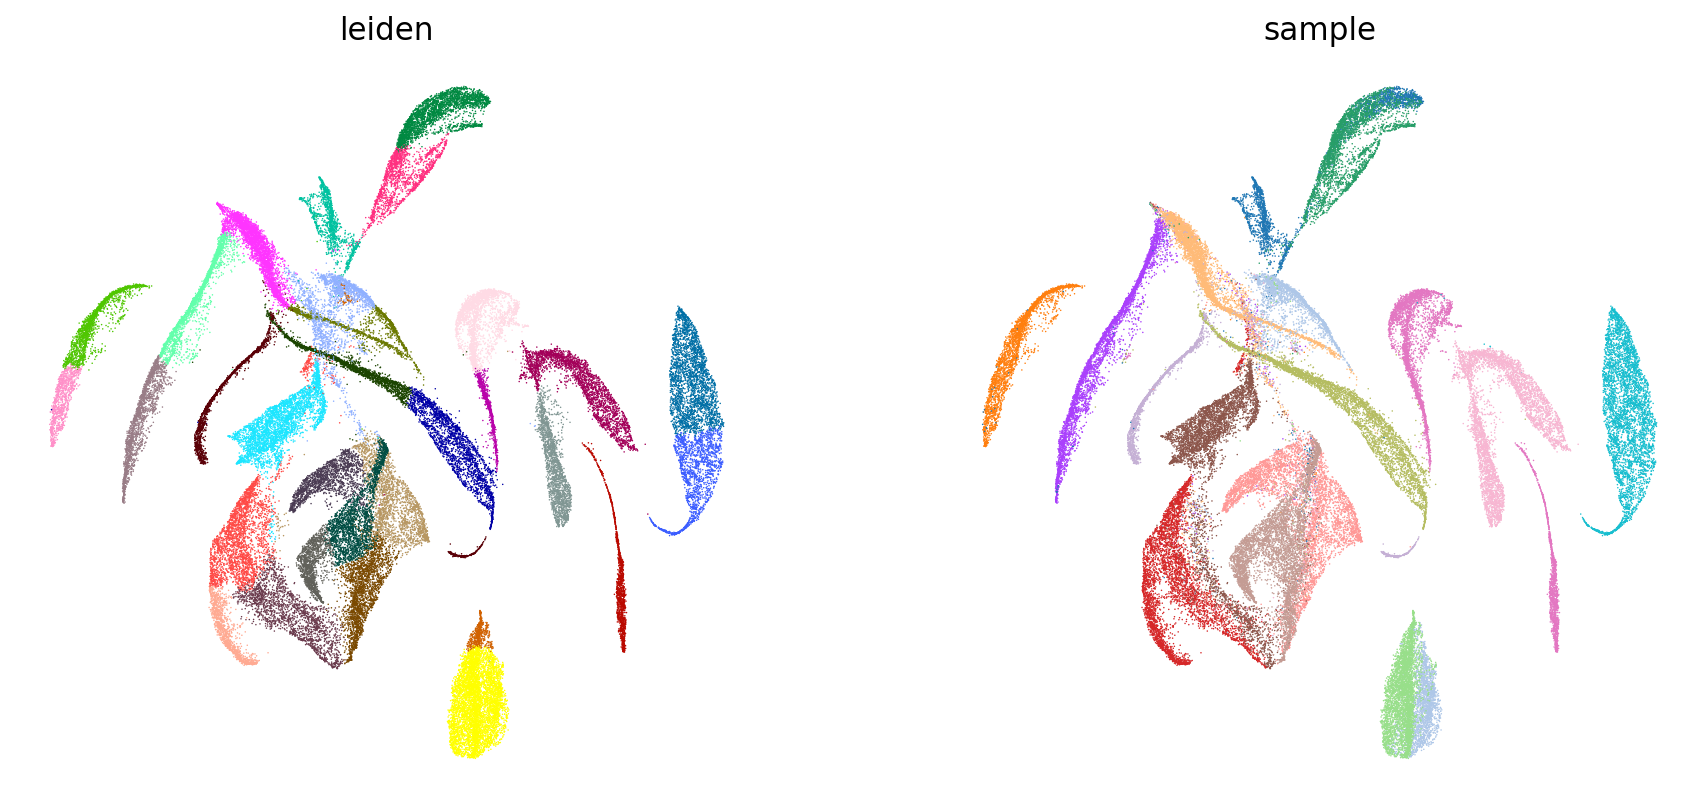

In [14]:
sc.pl.umap(adata, color=["leiden", "sample"], legend_loc="on", show=False)